In [1]:
### Imports

import os
import sys
import random
import time


import numpy as np

import torch
from torch.utils.data import Dataset

from torch import nn

from torch.nn import functional

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode

from tqdm import tqdm

from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.style.use('dark_background')
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

#### `svetlanna`

from svetlanna.units import ureg

from svetlanna import SimulationParameters
from svetlanna.parameters import ConstrainedParameter

from svetlanna import Wavefront
from svetlanna.transforms import ToWavefront

from svetlanna.elements import FreeSpace, Aperture, RectangularAperture, DiffractiveLayer
from svetlanna.setup import LinearOpticalSetup
from svetlanna.detector import Detector, DetectorProcessorClf

from svetlanna.visualization import show_stepwise_forward

from svetlanna.clerk import Clerk

#### `src`

# dataset of wavefronts
from src.wf_datasets import DatasetOfWavefronts

# training and evaluation loops
from src.clf_loops import onn_train_clf, onn_validate_clf
import itertools

In [2]:
c_const = 299_792_458 # [m / s]

working_frequency = 400 * ureg.GHz  # [Hz]
working_wavelength = c_const / working_frequency  # [m]

# neuron size (square)
neuron_size = 0.53 * working_wavelength  # [m]

print('Specified parameters:')
# uncomment next two lines!
print(f'lambda = {working_wavelength * 1e6:.3f} um')
print(f'neuron size = {neuron_size * 1e6:.3f} um') # IR

# an actual zone where weights will be updated during a training process
ALL_SIZE = (200, 200)  # for example (100, 100) neurons
USE_APERTURES = False

a
# number of neurons in simulation
x_layer_nodes = ALL_SIZE[1]
y_layer_nodes = ALL_SIZE[0]

# calculate physical size of each layer in [m]
x_layer_size_m = x_layer_nodes * neuron_size  # [m]
y_layer_size_m = y_layer_nodes * neuron_size

print(f'Layer size (in neurons): {x_layer_nodes} x {y_layer_nodes} = {x_layer_nodes * y_layer_nodes}')
print(f'Layer size (in cm): {x_layer_size_m * 1e2} x {y_layer_size_m * 1e2}')



# simulation parameters for the rest of the notebook!
SIM_PARAMS = SimulationParameters(
    axes={
        "W" : torch.linspace(-x_layer_size_m / 2, x_layer_size_m / 2, x_layer_nodes),
        "H" : torch.linspace(-y_layer_size_m / 2, y_layer_size_m / 2, y_layer_nodes),
        "wavelength": working_wavelength
    }
)

Specified parameters:
lambda = 749.481 um
neuron size = 397.225 um
Layer size (in neurons): 200 x 200 = 40000
Layer size (in cm): 7.944500137 x 7.944500137


In [3]:
# initialize a directory for a dataset
MNIST_DATA_FOLDER = './data'  # folder to store data

if not os.path.exists(MNIST_DATA_FOLDER):
    os.makedirs(MNIST_DATA_FOLDER)

In [4]:
# TRAIN (images)
mnist_train_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=True,  # for train dataset
    download=True,
)

# TEST (images)
mnist_test_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=False,  # for test dataset
    download=True,
)

In [5]:
# select modulation type
MODULATION_TYPE = 'amp'  # using ONLY amplitude to encode each picture in a Wavefront!

resize_y = int(DETECTOR_SIZE[0] / 2)
resize_x = int(DETECTOR_SIZE[1] / 2)  # shape for transforms.Resize

# paddings along OY
pad_top = int((y_layer_nodes - resize_y) / 2)
pad_bottom = y_layer_nodes - pad_top - resize_y
# paddings along OX
pad_left = int((x_layer_nodes - resize_x) / 2)
pad_right = x_layer_nodes - pad_left - resize_x  # params for transforms.Pad

# compose all transforms!
image_transform_for_ds = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(resize_y, resize_x),
          interpolation=InterpolationMode.NEAREST,
      ),
      transforms.Pad(
          padding=(
              pad_left,  # left padding
              pad_top,  # top padding
              pad_right,  # right padding
              pad_bottom  # bottom padding
          ),
          fill=0,
      ),  # padding to match sizes!
      ToWavefront(modulation_type=MODULATION_TYPE)  # <- select modulation type!!!
  ]  
)

In [6]:
# TRAIN dataset of WAVEFRONTS
mnist_wf_train_ds = DatasetOfWavefronts(
    init_ds=mnist_train_ds,  # dataset of images
    transformations=image_transform_for_ds,  # image transformation
    sim_params=SIM_PARAMS,  # simulation parameters
)

# TEST dataset of WAVEFRONTS
mnist_wf_test_ds = DatasetOfWavefronts(
    init_ds=mnist_test_ds,  # dataset of images
    transformations=image_transform_for_ds,  # image transformation
    sim_params=SIM_PARAMS,  # simulation parameters
)

print(f'Train data: {len(mnist_train_ds)}')
print(f'Test data : {len(mnist_test_ds)}')

Train data: 60000
Test data : 10000


In [7]:
mnist_train_ds[0][0]

In [8]:
def plot_examples(n_examples= 4, seed=78):
    random.seed(seed)
    train_examples_ids = random.sample(range(len(mnist_train_ds)), n_examples)
    
    all_examples_wavefronts = []
    
    n_lines = 3
    fig, axs = plt.subplots(n_lines, n_examples, figsize=(n_examples * 3, n_lines * 3.2))
    for ind_ex, ind_train in enumerate(train_examples_ids):
        image, label = mnist_train_ds[ind_train]
        
        axs[0][ind_ex].set_title(f'id={ind_train} [{label}]')
        axs[0][ind_ex].imshow(image, cmap='gray')
    
        wavefront, wf_label = mnist_wf_train_ds[ind_train]
        assert isinstance(wavefront, Wavefront)
    
        all_examples_wavefronts.append(wavefront)
    
        axs[1][ind_ex].set_title(f'$|WF|^2$')
        axs[1][ind_ex].imshow(wavefront.intensity, cmap='gray')
        
        axs[2][ind_ex].set_title(f'phase of $WF$')
        axs[2][ind_ex].imshow(wavefront.phase, cmap='gray')
#plot_examples()

In [9]:
NUM_OF_DIFF_LAYERS = 3  # number of diffractive layers
FREE_SPACE_DISTANCE = 40 * working_wavelength  # [m] - distance between difractive layers

print(f'Distance between layers is {FREE_SPACE_DISTANCE * 1e2:.3f} cm')

Distance between layers is 2.998 cm


In [55]:
MAX_PHASE = 2 * np.pi

FREESPACE_METHOD = 'AS'  # we use an angular spectrum method

INIT_PHASES = torch.ones(NUM_OF_DIFF_LAYERS) * np.pi # todo: was ones

In [56]:
# TAKE A LOOK! CODE HERE IS READY
import svetlanna.parameters as params
def get_const_phase_layer(
    sim_params: SimulationParameters,
    value: float, 
    max_phase=2 * torch.pi
):
    """
    Returns DiffractiveLayer with a constant phase mask.
    """
    x_nodes, y_nodes = sim_params.axes_size(axs=('W', 'H'))

    const_mask = torch.ones(size=(y_nodes, x_nodes))* value
    
    return DiffractiveLayer(
        simulation_parameters=sim_params,
        mask=params.Parameter(const_mask) 
    )
    #
    #ConstrainedParameter(
    #        const_mask,
    #        min_value=0,
    #        max_value=max_phase
    #    ),  # HERE WE ARE USING CONSTRAINED PARAMETER! Phases are learnable!

In [57]:
def get_elements_list(
    num_layers,
    simulation_parameters,
    freespace_method,
    phase_values,
    apertures=False,
    aperture_size=(100, 100)
):
    free_space = lambda: FreeSpace(simulation_parameters, FREE_SPACE_DISTANCE, freespace_method) # Here happens unnecessary blurring. Or not?
    aperture = lambda: [RectangularAperture(simulation_parameters, aperture_size)] if apertures else []
    layer = lambda i: aperture() + [get_const_phase_layer(simulation_parameters, phase_values[i]), free_space()]
    layers = list(itertools.chain(*map(layer, range(num_layers))))
    return [free_space()] + layers + aperture() + [Detector(simulation_parameters,'intensity',)]

In [58]:
architecture_elements_list = get_elements_list(
    num_layers=NUM_OF_DIFF_LAYERS,
    simulation_parameters=SIM_PARAMS,
    freespace_method=FREESPACE_METHOD,
    phase_values=INIT_PHASES,
    apertures=USE_APERTURES,
    aperture_size=DETECTOR_SIZE
)
architecture_elements_list

[FreeSpace(),
 DiffractiveLayer(
   (mask_svtlnn_inner_parameter): InnerParameterStorageModule()
 ),
 FreeSpace(),
 DiffractiveLayer(
   (mask_svtlnn_inner_parameter): InnerParameterStorageModule()
 ),
 FreeSpace(),
 DiffractiveLayer(
   (mask_svtlnn_inner_parameter): InnerParameterStorageModule()
 ),
 FreeSpace(),
 Detector()]

In [59]:
print(f'Number of elements in the system (including Detector): {len(architecture_elements_list)}')

Number of elements in the system (including Detector): 8


In [60]:
def get_setup(simulation_parameters, apertures=False):
    """
    Returns an optical setup. Recreates all elements.
    """
    elements_list = get_elements_list(
        num_layers=NUM_OF_DIFF_LAYERS,
        simulation_parameters=SIM_PARAMS,
        freespace_method=FREESPACE_METHOD,
        phase_values=INIT_PHASES,
        apertures=apertures,
        aperture_size=DETECTOR_SIZE
    )  # recreate a list of elements

    return LinearOpticalSetup(elements=elements_list)

In [61]:
# creaye an optical setup
optical_setup = get_setup(SIM_PARAMS, apertures=USE_APERTURES)

In [62]:
# TODO: Check the architecture!

In [63]:
optical_setup.net

Sequential(
  (0): FreeSpace()
  (1): DiffractiveLayer(
    (mask_svtlnn_inner_parameter): InnerParameterStorageModule()
  )
  (2): FreeSpace()
  (3): DiffractiveLayer(
    (mask_svtlnn_inner_parameter): InnerParameterStorageModule()
  )
  (4): FreeSpace()
  (5): DiffractiveLayer(
    (mask_svtlnn_inner_parameter): InnerParameterStorageModule()
  )
  (6): FreeSpace()
  (7): Detector()
)

In [64]:
random_ind = np.random.randint(0, len(mnist_wf_train_ds))

example_wf, example_label = mnist_wf_train_ds[random_ind]

In [65]:
print(f'Label of selected wavefront: {example_label}')

Label of selected wavefront: 1


In [66]:
if 0:
    show_stepwise_forward(
    optical_setup,
    input= example_wf,  # TODO: add a wavefront to propagate!
    simulation_parameters=SIM_PARAMS,
    types_to_plot=("I", "phase")  # TODO: check different types! 
    )

In [67]:
NUMBER_OF_CLASSES = 10

In [68]:
detector_segment_size = 6.4 * working_wavelength  # in neurons (int)
detector_segment_size_m = detector_segment_size // neuron_size  # in [m]
detector_segment_size_m

12.0

In [69]:
def get_detector_mask(
    segment_size_in_neurons : int,
    segment_dist : int,
    order_of_digits=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
):
    if not len(order_of_digits) == NUMBER_OF_CLASSES:
        print('Wrong ordering list!')

    t = torch.ones(ALL_SIZE) * -1
    upper = [(-1, 1), (0, 1), (1, 1)]
    lower = [(-1, -1), (0, -1), (1, -1)]
    middle = [(-1.5, 0), (-0.5, 0), (0.5, 0), (1.5, 0)]
    
    for i, (x, y) in enumerate(lower + middle + upper):
        if not i in order_of_digits:
            print('Wrong ordering list!')
        x_start = int(segment_size_in_neurons + x * segment_dist + ALL_SIZE[1] // 2 - segment_size_in_neurons // 2 - segment_dist // 2)
        y_start = int(segment_size_in_neurons + y * segment_dist + ALL_SIZE[0] // 2 - segment_size_in_neurons // 2 - segment_dist // 2)
        t[y_start: y_start + int(segment_size_in_neurons), x_start: x_start + int(segment_size_in_neurons)] = order_of_digits[i]
        print(f'Adding segment for class {order_of_digits[i]} which is {i}th at ({x_start}, {y_start})')
    return t

Adding segment for class 0 which is 0th at (70, 70)
Adding segment for class 1 which is 1th at (94, 70)
Adding segment for class 2 which is 2th at (118, 70)
Adding segment for class 3 which is 3th at (58, 94)
Adding segment for class 4 which is 4th at (82, 94)
Adding segment for class 5 which is 5th at (106, 94)
Adding segment for class 6 which is 6th at (130, 94)
Adding segment for class 7 which is 7th at (70, 118)
Adding segment for class 8 which is 8th at (94, 118)
Adding segment for class 9 which is 9th at (118, 118)


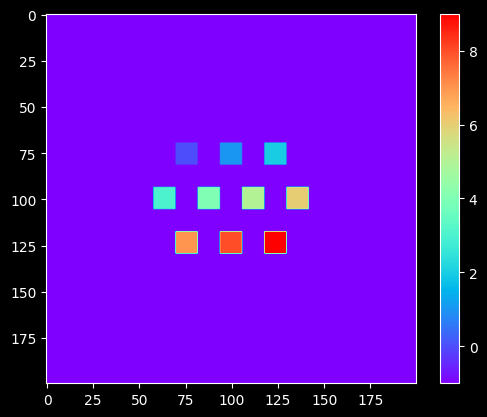

In [70]:
plt.imshow(get_detector_mask(detector_segment_size_m, detector_segment_size_m * 2), cmap='rainbow', vmin=-1, vmax=9)
plt.colorbar()

In [71]:
ZONES_ORDER = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # TODO% specify the order

In [72]:
DETECTOR_MASK = get_detector_mask(detector_segment_size_m, detector_segment_size_m * 2, ZONES_ORDER)

Adding segment for class 0 which is 0th at (70, 70)
Adding segment for class 1 which is 1th at (94, 70)
Adding segment for class 2 which is 2th at (118, 70)
Adding segment for class 3 which is 3th at (58, 94)
Adding segment for class 4 which is 4th at (82, 94)
Adding segment for class 5 which is 5th at (106, 94)
Adding segment for class 6 which is 6th at (130, 94)
Adding segment for class 7 which is 7th at (70, 118)
Adding segment for class 8 which is 8th at (94, 118)
Adding segment for class 9 which is 9th at (118, 118)


In [73]:
# create a DetectorProcessorOzcanClf object
DETECTOR_PROCESSOR = DetectorProcessorClf(
    simulation_parameters=SIM_PARAMS,
    num_classes=NUMBER_OF_CLASSES,
    segmented_detector=DETECTOR_MASK,
)

In [74]:
ZONES_HIGHLIGHT_COLOR = 'w'
ZONES_LW = 0.5
selected_detector_mask = DETECTOR_PROCESSOR.segmented_detector.clone().detach()

In [75]:
def get_zones_patches(detector_mask, delta = 0.5):
    def zone_patch(ind_class):
        idx_y, idx_x = (detector_mask == ind_class).nonzero(as_tuple=True)
        return patches.Rectangle(
            (idx_x[0] - delta, idx_y[0] - delta), 
            idx_x[-1] - idx_x[0] + 2 * delta, idx_y[-1] - idx_y[0] + 2 * delta, 
            linewidth=ZONES_LW, 
            edgecolor=ZONES_HIGHLIGHT_COLOR,
            facecolor='none'
        )
    return [zone_patch(i) for i in range(NUMBER_OF_CLASSES)] # TODO: Zone order matters? 

In [76]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_bs = 20  # a batch size for training set
val_bs = 8

# TODO: specify a random seed
train_val_split_seed = 40

In [77]:
# mnist_wf_train_ds
train_wf_ds, val_wf_ds = torch.utils.data.random_split(
    dataset=mnist_wf_train_ds,
    lengths=[55000, 5000],  # sizes from the article
    generator=torch.Generator().manual_seed(train_val_split_seed)  # for reproducibility
)

In [78]:
train_wf_loader = torch.utils.data.DataLoader(
    train_wf_ds,
    batch_size=train_bs,
    shuffle=True,
    # num_workers=2,
    drop_last=False,
)

val_wf_loader = torch.utils.data.DataLoader(
    val_wf_ds,
    batch_size=val_bs,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)

In [79]:
LR = 1e-3

In [80]:
def get_adam_optimizer(net):
    return torch.optim.Adam(
        params=net.parameters(),  # NETWORK PARAMETERS!
        lr=LR
    )

In [81]:
loss_func_clf = nn.CrossEntropyLoss()
loss_func_name = 'CE loss'

In [82]:
# we are just importing them from src folder
from src.clf_loops import onn_train_clf, onn_validate_clf

In [83]:
test_wf_loader = torch.utils.data.DataLoader(
    mnist_wf_test_ds,
    batch_size=10,
    shuffle=False,
    # num_workers=2
    drop_last=False,
)  # data loader for a test MNIST data

In [84]:
if 0:
    test_losses_0, _, test_accuracy_0 = onn_validate_clf(
        optical_setup.net,  # optical network composed in 3.
        test_wf_loader,  # dataloader of training set
        DETECTOR_PROCESSOR,  # detector processor
        loss_func_clf,
        device=DEVICE,
        show_process=True,
    )  # evaluate the model
    
    print(
        'Results before training on TEST set:\n' + 
        f'\t{loss_func_name} : {np.mean(test_losses_0):.6f}\n' +
        f'\tAccuracy : {(test_accuracy_0 * 100):>0.1f} %'
    )

In [85]:
NUM_EPOCHS = 3

TORCH_SEED = 4

today_date = datetime.today().strftime('%d-%m-%Y_%H-%M')  # date for a results folder name

RESULTS_FOLDER = f'results/exp_{today_date}'
RESULTS_FOLDER

VARIABLES = {    
    'wavelength': working_wavelength,  # working wavelength, in [m]
    'neuron_size': neuron_size,  # size of a pixel for DiffractiveLayers, in [m]
    'mesh_size': ALL_SIZE,  # full size of a layer = numerical mesh
    'use_apertures': USE_APERTURES,  # if we need to add apertures before each DiffractieLayer
    'aperture_size': DETECTOR_SIZE,  # size of each aperture = a detector square for classes zones
    
    # DETECTOR ZONES
    'detector_segment_size': detector_segment_size_m,  # size of each square class zone on a detector, in [m]
    'segments_order': ZONES_ORDER,

    # RANDOM SEEDS
    'train_val_seed': train_val_split_seed,
    'torch_seed': TORCH_SEED,
    
    # NETWORK - SECTION 3 of the notebook
    'free_space_distance': FREE_SPACE_DISTANCE,  # constant free space distance for a network, in [m]
    
    # OPTICAL NETWORK LEARNING - SECTION 4 of the notebook
    'train_batch_size': train_bs,  # batch sizes for training
    'val_batch_size': val_bs,
    'adam_lr': LR,  # learning rate for Adam optimizer
    'number_of_epochs': NUM_EPOCHS,  # number of epochs to train
}

In [86]:
if not os.path.exists(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)

In [87]:
import json
# save experiment conditions (VARIABLES dictionary)
with open(f'{RESULTS_FOLDER}/conditions.json', 'w', encoding ='utf8') as json_file:
    json.dump(VARIABLES, json_file, ensure_ascii = True)

In [88]:
torch.save(DETECTOR_MASK, f'{RESULTS_FOLDER}/detector_mask.pt')

In [89]:
print_each = 1  # print each n'th epoch info

In [90]:
scheduler = None  # sheduler for a lr tuning during training 

In [91]:
# Recreate a system to restart training!
optical_setup_to_train = get_setup(SIM_PARAMS, apertures=USE_APERTURES)
# Link optimizer to a recreated net!
optimizer_clf = get_adam_optimizer(optical_setup_to_train.net)

In [92]:
train_epochs_losses = []
val_epochs_losses = []  # to store losses of each epoch

train_epochs_acc = []
val_epochs_acc = []  # to store accuracies

torch.manual_seed(TORCH_SEED)

for epoch in range(NUM_EPOCHS):
    if (epoch == 0) or ((epoch + 1) % print_each == 0) or (epoch == n_epochs - 1):
        print(f'Epoch #{epoch + 1} of {NUM_EPOCHS}: ', end='')
        show_progress = True
    else:
        show_progress = False

    # TRAIN
    start_train_time = time.time()  # start time of the epoch (train)
    train_losses, _, train_accuracy = onn_train_clf(
        optical_setup_to_train.net,  # optical network composed in 3.
        train_wf_loader,  # dataloader of training set
        DETECTOR_PROCESSOR,  # detector processor
        loss_func_clf,
        optimizer_clf,
        device=DEVICE,
        show_process=show_progress,
    )  # train the model
    mean_train_loss = np.mean(train_losses)
    
    if (epoch == 0) or ((epoch + 1) % print_each == 0) or (epoch == n_epochs - 1):  # train info
        print('Training results')
        print(f'\t{loss_func_name} : {mean_train_loss:.6f}')
        print(f'\tAccuracy : {(train_accuracy*100):>0.1f} %')
        print(f'\t------------   {time.time() - start_train_time:.2f} s')

    # VALIDATION
    start_val_time = time.time()  # start time of the epoch (validation)
    val_losses, _, val_accuracy = onn_validate_clf(
        optical_setup_to_train.net,  # optical network composed in 3.
        val_wf_loader,  # dataloader of validation set
        DETECTOR_PROCESSOR,  # detector processor
        loss_func_clf,
        device=DEVICE,
        show_process=show_progress,
    )  # evaluate the model
    mean_val_loss = np.mean(val_losses)
    
    if (epoch == 0) or ((epoch + 1) % print_each == 0) or (epoch == n_epochs - 1):  # validation info
        print('Validation results')
        print(f'\t{loss_func_name} : {mean_val_loss:.6f}')
        print(f'\tAccuracy : {(val_accuracy*100):>0.1f} %')
        print(f'\t------------   {time.time() - start_val_time:.2f} s')
            
    if scheduler:
        scheduler.step(mean_val_loss) 
    
    # save losses
    train_epochs_losses.append(mean_train_loss)
    val_epochs_losses.append(mean_val_loss)
    # seve accuracies
    train_epochs_acc.append(train_accuracy)
    val_epochs_acc.append(val_accuracy)

Epoch #1 of 3: 

train: 100%|████████████████████████████████| 2750/2750 [08:11<00:00,  5.59it/s]


Training results
	CE loss : 2.136797
	Accuracy : 49.2 %
	------------   491.88 s


validation: 100%|█████████████████████████████| 625/625 [00:24<00:00, 25.13it/s]


Validation results
	CE loss : 2.028201
	Accuracy : 69.9 %
	------------   24.87 s
Epoch #2 of 3: 

train: 100%|████████████████████████████████| 2750/2750 [07:38<00:00,  6.00it/s]


Training results
	CE loss : 1.982592
	Accuracy : 75.5 %
	------------   458.58 s


validation: 100%|█████████████████████████████| 625/625 [00:23<00:00, 26.13it/s]


Validation results
	CE loss : 1.945290
	Accuracy : 79.3 %
	------------   23.92 s
Epoch #3 of 3: 

train: 100%|████████████████████████████████| 2750/2750 [07:43<00:00,  5.94it/s]


Training results
	CE loss : 1.924811
	Accuracy : 80.4 %
	------------   463.08 s


validation: 100%|█████████████████████████████| 625/625 [00:28<00:00, 21.74it/s]

Validation results
	CE loss : 1.908081
	Accuracy : 81.3 %
	------------   28.75 s


In [93]:
# ADAM+2pi filter: 532  24 488 23 438 22(s)
# validation losses: 0.7656 0.8194 0.8294

# SGD+2pi filter: the same!
# Losses: Terrible! 14-15 percents.

# ADAM without constrained parameters:
# Losses:??? 70 79 81.4


In [50]:
# array with all losses

all_lasses_header = ','.join([
    f'{loss_func_name.split()[0]}_train', f'{loss_func_name.split()[0]}_val',
    'accuracy_train', 'accuracy_val'
])
all_losses_array = np.array(
    [train_epochs_losses, val_epochs_losses, train_epochs_acc, val_epochs_acc]
).T

In [51]:
# filepath to save losses
losses_filepath = f'{RESULTS_FOLDER}/training_curves.csv'

In [52]:
# saving losses
np.savetxt(
    losses_filepath, all_losses_array,
    delimiter=',', header=all_lasses_header, comments=""
)

#### Save model weights

In [53]:
# filepath to save the model
model_filepath = f'{RESULTS_FOLDER}/optical_net.pth'

In [54]:
# saving model
torch.save(optical_setup_to_train.net.state_dict(), model_filepath)